In [111]:
import keras 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import metrics
import operator

In [6]:
# LOAD DATA

import pickle # Load pickled data
import numpy as np

# Data files
training_file = "data_trafficsigns/train.p"
testing_file = "data_trafficsigns/test.p"
validation_file = "data_trafficsigns/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape)

(34799, 32, 32, 3)


In [8]:
# DATA SUMMARY

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validating examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validating examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [77]:
#### Mapping label id values to names for all signs
import pandas as pd

labels_signs = pd.read_csv("./signnames.csv", delimiter=',')
counts = labels_signs.copy()

counts.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [78]:
labels_signs.loc[0]['SignName']

'Speed limit (20km/h)'

In [81]:
len(labels_signs.loc[:]['ClassId'])

43

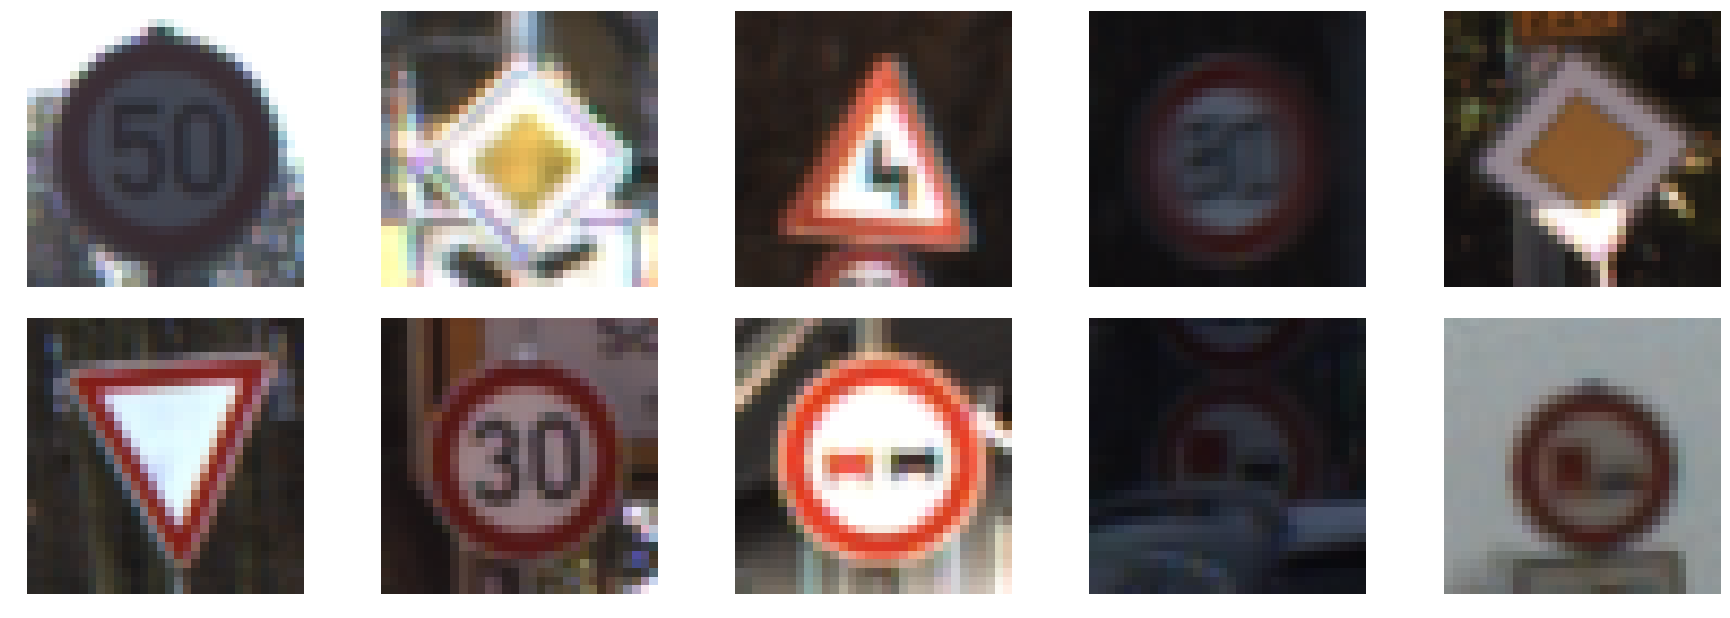

In [10]:
### Data exploration visualization code goes here.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
f, (plot) = plt.subplots(2, 5, figsize=(24, 9))
plot = np.ravel(plot) #Flattens the array for viz
f.tight_layout()
for ax in plot:
    index = random.randint(0, len(X_train))
    img = X_train[index].squeeze()
    id_sign = y_train[index]
    ax.imshow(img)
    ax.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
model = Sequential()
#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 6, 
                 kernel_size = 5, 
                 strides = 1, 
                 activation = 'relu', 
                 input_shape = (32,32,3)))
#Pooling layer 1
model.add(MaxPooling2D(pool_size = 2, strides = 2))
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, 
                 kernel_size = 5,
                 strides = 1,
                 activation = 'relu',
                 input_shape = (14,14,6)))
#Pooling Layer 2
model.add(MaxPooling2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
#Layer 5
#Output Layer
model.add(Dense(units = 43, activation = 'softmax'))

In [19]:
#Model Hyperparamaters
nb_classes = 43 #(43 types of conditions to detect)
batch_size = 32
dropout = 0.50
epochs = 5

In [26]:
# Convert Labels to ONE-HOT encoders
lb = LabelBinarizer()
lb.fit(y_train)
y_train_labels = lb.transform(y_train)

test_lb = LabelBinarizer()
test_lb.fit(y_test)
y_test_labels = test_lb.transform(y_test)

test_lb = LabelBinarizer()
test_lb.fit(y_valid)
y_valid_labels = test_lb.transform(y_valid)

In [69]:
print(y_train[0])
print(y_train_labels[0])

41
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0]
[41 41 41 ... 25 25 25]


In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/trafficsigns_.h5', 
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1, mode='auto')

hist = model.fit(np.array(X_train), np.array(y_train_labels), 
          validation_data=(np.array(X_valid), np.array(y_valid_labels)),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 29s 826us/step - loss: 1.2631 - acc: 0.7179 - val_loss: 0.7906 - val_acc: 0.8283

Epoch 00001: val_loss improved from inf to 0.79063, saving model to saved_models/trafficsigns_.h5
Epoch 2/5
34799/34799 [==============================] - 27s 779us/step - loss: 0.2725 - acc: 0.9290 - val_loss: 0.7502 - val_acc: 0.8626

Epoch 00002: val_loss improved from 0.79063 to 0.75021, saving model to saved_models/trafficsigns_.h5
Epoch 3/5
34799/34799 [==============================] - 26s 754us/step - loss: 0.2089 - acc: 0.9479 - val_loss: 0.6753 - val_acc: 0.8764

Epoch 00003: val_loss improved from 0.75021 to 0.67528, saving model to saved_models/trafficsigns_.h5
Epoch 4/5
34799/34799 [==============================] - 34s 964us/step - loss: 0.1553 - acc: 0.9610 - val_loss: 0.7646 - val_acc: 0.8844

Epoch 00004: val_loss did not improve from 0.67528
Epoch 5/5
34799/34799 [===================

'hist = model.fit_generator(train_generator, \n          validation_data=valid_generator,\n          epochs=epochs, steps_per_epoch= 1000 // batch_size,validation_steps=150 // batch_size,\n                           callbacks=[checkpointer, early_stopping], verbose=1)'

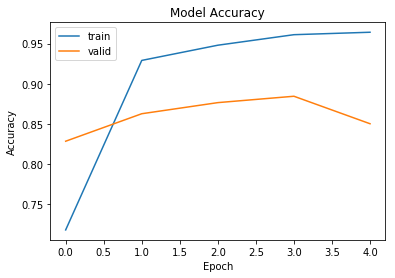

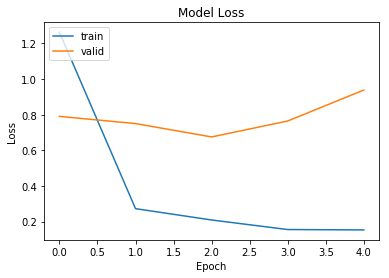

In [30]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [82]:
def predict_image(model, img_matrix): 
    '''
    This function accepts the final model from above and returns a classification of all all three types. 
    ***Args***
    model: CNN Trained above
    img_matrix: image data in a numpy array'''
    img = np.expand_dims(img_matrix, axis=0)
    img = preprocess_input(img)
    return model.predict(img)

def convert_prediction(values):
    '''
    This function accepts a numpy array of predicted values and returns a dictionary of predictions of each label.
    ***Args***
    values: Numpy Array of predicted values.'''
    # labels = ['Melanoma', 'Nevus', 'Seborrheic Keratosis']
    labels = labels_signs.loc[:]['ClassId']
    value_hash = {}
    for i in range(len(labels)):
        value_hash[labels[i]] = values[0][i]
    return value_hash

In [64]:
values = predict_image(model, np.array(X_test[2]))

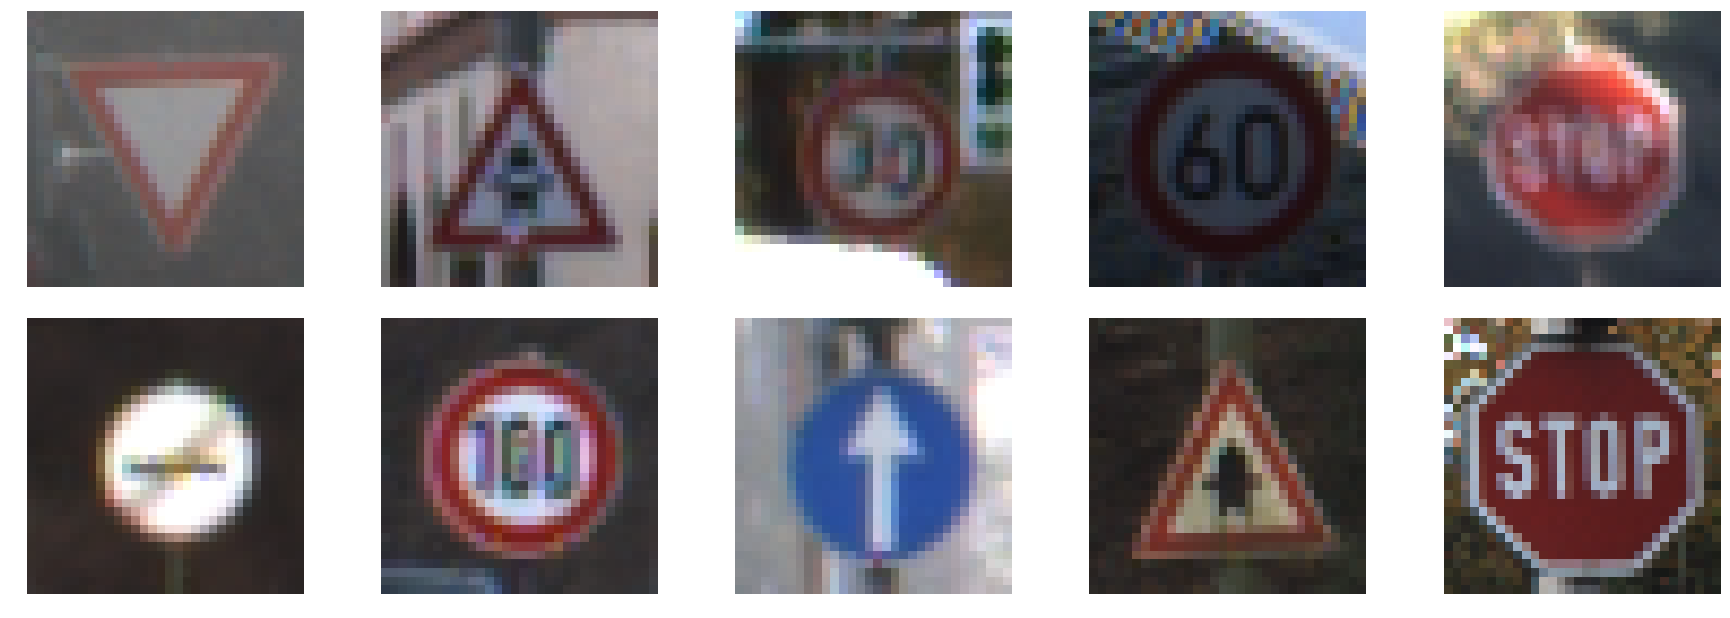

In [66]:
# Visualizations will be shown in the notebook.
%matplotlib inline
f, (plot) = plt.subplots(2, 5, figsize=(24, 9))
plot = np.ravel(plot) #Flattens the array for viz
f.tight_layout()
for ax in plot:
    index = random.randint(0, len(X_test))
    img = X_test[index].squeeze()
    id_sign = y_test[index]
    ax.imshow(img)
    ax.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [129]:
print('\nPredicting with the Model ... ')
y_pred = []
for test_idx in range(len(X_test)):
    
    values = predict_image(model, np.array(X_test[test_idx]))
    
    predictions = convert_prediction(values)
    pred_test = max(predictions.items(), key=operator.itemgetter(1))[0]
    y_pred.append(pred_test)
    true_test = np.argmax(np.array(y_test_labels[test_idx]))
    print('****************************************',end='\n')
    #print(tst_filename[test_idx])
    #print('It is {0} with a confidence of {1:.2f} %'.format(pred_test,predictions[pred_test]*100))
    print('It is <{0}> with a confidence of {1:.2f} %'.format(labels_signs.loc[pred_test]['SignName'],predictions[pred_test]*100))
    
    #print('True Label: {0}'.format(y_test[test_idx]))
    print('True Label: <{0}>'.format(labels_signs.loc[y_test[test_idx]]['SignName']))
    print('****************************************',end='\n')


Predicting with the Model ... 
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.66 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 16.00 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 15.64 %
True Label: <Keep right>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 25.62 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.44 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Keep right> with a confidence 

****************************************
It is <Road work> with a confidence of 6.34 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.89 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 14.15 %
True Label: <Double curve>
****************************************
****************************************
It is <Speed limit (70km/h)> with a confidence of 6.17 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.25 %
True Label: <Road work>
****************************************
****************************************
It is <General caution> with a confidence of 5.25 %
True Label: <Speed limit (100km/h)>
****************************************
************************

****************************************
It is <Speed limit (80km/h)> with a confidence of 7.05 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.76 %
True Label: <General caution>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 6.82 %
True Label: <No passing>
****************************************
****************************************
It is <Yield> with a confidence of 17.16 %
True Label: <Yield>
****************************************
****************************************
It is <Stop> with a confidence of 10.87 %
True Label: <Stop>
****************************************
****************************

****************************************
It is <Keep right> with a confidence of 9.52 %
True Label: <Go straight or right>
****************************************
****************************************
It is <Turn left ahead> with a confidence of 30.24 %
True Label: <Turn left ahead>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 6.61 %
True Label: <Children crossing>
****************************************
****************************************
It is <Ahead only> with a confidence of 18.29 %
True Label: <Ahead only>
****************************************
****************************************
It is <Keep right> with a confidence of 5.42 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 9.91 %
True Label: <Road work>
****************************************
****************************************
It

****************************************
It is <Road work> with a confidence of 8.39 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.63 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.66 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.22 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.77 %
True Label: <Wild animals crossing>
******************************

****************************************
It is <Road work> with a confidence of 7.92 %
True Label: <Ahead only>
****************************************
****************************************
It is <Road work> with a confidence of 14.57 %
True Label: <Road work>
****************************************
****************************************
It is <Turn left ahead> with a confidence of 20.93 %
True Label: <Turn left ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.56 %
True Label: <Priority road>
****************************************
****************************************
It is <Traffic signals> with a confidence of 6.31 %
True Label: <No entry>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.33 %
True Label: <No passing>
****************************************
****************************

****************************************
It is <Wild animals crossing> with a confidence of 8.85 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.57 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 6.04 %
True Label: <Stop>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.92 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.61 %
True Label: <Traffic signals>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.26 %
True Label: <Speed limit (70km/h)>

****************************************
It is <Priority road> with a confidence of 34.90 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.86 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.38 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 16.28 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 10.34 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Priority road> with a confidence of 17.80 %
True Label: <Priority road>
************************

****************************************
It is <Wild animals crossing> with a confidence of 7.38 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.15 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Road work> with a confidence of 6.03 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 5.26 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.71 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.72 %
True Label: <Dangerous curve to the left>


****************************************
It is <Road work> with a confidence of 7.20 %
True Label: <Ahead only>
****************************************
****************************************
It is <Ahead only> with a confidence of 16.42 %
True Label: <Ahead only>
****************************************
****************************************
It is <Stop> with a confidence of 5.67 %
True Label: <Stop>
****************************************
****************************************
It is <Road work> with a confidence of 7.06 %
True Label: <Road work>
****************************************
****************************************
It is <No entry> with a confidence of 8.81 %
True Label: <No entry>
****************************************
****************************************
It is <Yield> with a confidence of 5.69 %
True Label: <Turn left ahead>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.7

****************************************
It is <Road work> with a confidence of 7.97 %
True Label: <Keep left>
****************************************
****************************************
It is <Priority road> with a confidence of 36.99 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.31 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.15 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.41 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 6.29 %
True Label: <Speed limit (50km/h)>
*************************

****************************************
It is <Wild animals crossing> with a confidence of 3.98 %
True Label: <No passing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.14 %
True Label: <No vehicles>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 4.71 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Priority road> with a confidence of 47.50 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.42 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.20 %
True Labe

****************************************
It is <Wild animals crossing> with a confidence of 8.87 %
True Label: <Double curve>
****************************************
****************************************
It is <Road work> with a confidence of 6.92 %
True Label: <Keep right>
****************************************
****************************************
It is <Keep right> with a confidence of 55.55 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.90 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 16.17 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.08 %
True Label: <Slippery road>
****************************************
*************************************

****************************************
It is <Wild animals crossing> with a confidence of 7.14 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 4.40 %
True Label: <No vehicles>
****************************************
****************************************
It is <Road work> with a confidence of 6.90 %
True Label: <Priority road>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 6.89 %
True Label: <Stop>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 4.30 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.85 %
True Label: <Speed limit (80km/h)>


****************************************
It is <Road work> with a confidence of 6.81 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.86 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.46 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.39 %
True Label: <End of no passing>
****************************************
****************************************
It is <Yield> with a confidence of 7.27 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.82 %
True Label: <Speed limit (50km/h

****************************************
It is <Wild animals crossing> with a confidence of 7.10 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.81 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.24 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.75 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 5.78 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 8.98 %
True Label: <Spee

****************************************
It is <Road work> with a confidence of 6.77 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.10 %
True Label: <Road work>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 6.74 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.47 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 17.16 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.32 %
True Label: <Speed limit (70km/h)>
****************

****************************************
It is <Wild animals crossing> with a confidence of 7.27 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Road work> with a confidence of 6.21 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.66 %
True Label: <Yield>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 7.46 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.85 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.21 %
True Label: <Right-of-way at the next intersection>
*******************

****************************************
It is <Wild animals crossing> with a confidence of 6.55 %
True Label: <End of no passing by vehicles over 3.5 metric tons>
****************************************
****************************************
It is <General caution> with a confidence of 7.13 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 5.38 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 5.26 %
True Label: <Stop>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.75 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.73 %
True Label: <Priority road>
*******************************

****************************************
It is <Wild animals crossing> with a confidence of 6.03 %
True Label: <Children crossing>
****************************************
****************************************
It is <Priority road> with a confidence of 8.57 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.53 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.19 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.78 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.78 %
True Label: <Speed limit (60km/h)>
****************

****************************************
It is <Road work> with a confidence of 6.45 %
True Label: <No entry>
****************************************
****************************************
It is <Priority road> with a confidence of 27.17 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.12 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.61 %
True Label: <No vehicles>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.55 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.89 %
True Label: <General caution>
****************************************
***************

****************************************
It is <Wild animals crossing> with a confidence of 6.75 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.48 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.74 %
True Label: <Dangerous curve to the right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 4.82 %
True Label: <No vehicles>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.75 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.51 %
True Label: <Speed limit (60km/h)>
*****

****************************************
It is <Wild animals crossing> with a confidence of 7.38 %
True Label: <General caution>
****************************************
****************************************
It is <Keep right> with a confidence of 11.97 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 9.57 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Priority road> with a confidence of 16.69 %
True Label: <Priority road>
****************************************
****************************************
It is <Keep right> with a confidence of 55.14 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.74 %
True Label: <Yield>
****************************************
*************************

****************************************
It is <Road work> with a confidence of 6.05 %
True Label: <Stop>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.40 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 6.45 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Keep right> with a confidence of 11.79 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 5.43 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 7.02 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
*************

****************************************
It is <Road work> with a confidence of 5.99 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.08 %
True Label: <Slippery road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 9.13 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Keep right> with a confidence of 36.37 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.00 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.03 %
True Label: <Keep right>
****************************************
**********

****************************************
It is <Turn right ahead> with a confidence of 18.49 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.41 %
True Label: <General caution>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.21 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.96 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.39 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 4.97 %
True Label: <Speed limit (70km/h)>
*************************

****************************************
It is <Road work> with a confidence of 6.83 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.64 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.89 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.84 %
True Label: <Children crossing>
****************************************
****************************************
It is <Keep right> with a confidence of 8.88 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.18 %
True Label: <Vehicles over 3.5 metric tons prohibite

****************************************
It is <Wild animals crossing> with a confidence of 7.52 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.55 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.62 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Keep right> with a confidence of 23.69 %
True Label: <Keep right>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.41 %
True Label: <No passing>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 9.13 %
True Label: <End 

****************************************
It is <Keep right> with a confidence of 47.62 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.82 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.37 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Keep right> with a confidence of 10.13 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.52 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.50 %
True Label: <Bumpy road>
****************************************
***********************

****************************************
It is <Wild animals crossing> with a confidence of 4.96 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.30 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 7.54 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.77 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.85 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.58 %
True Label: <Bumpy road>
****************************************
**

****************************************
It is <General caution> with a confidence of 4.46 %
True Label: <Priority road>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 6.97 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.68 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.19 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.19 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.03 %
True Label: <Speed limit (60km/h)>
********************

****************************************
It is <Road work> with a confidence of 11.94 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 5.95 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 10.46 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 9.72 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 5.88 %
True Label: <General caution>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.50 %
True Label: <Speed limit (30km/h)>
****************************************
********************************

****************************************
It is <Wild animals crossing> with a confidence of 7.21 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.70 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.33 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 6.74 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 6.47 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 11.47 %
True Label: <Priority road>
****************************************

****************************************
It is <Wild animals crossing> with a confidence of 5.55 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.01 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 9.42 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.29 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 5.00 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 5.29 %
True Label: <Priority road>
***********************

****************************************
It is <Wild animals crossing> with a confidence of 5.96 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 6.88 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 6.98 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 5.62 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.73 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.02 %
True Label: <Road work>
****************************************
**********

****************************************
It is <Wild animals crossing> with a confidence of 6.49 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.39 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 4.16 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.03 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.33 %
True Label: <General caution>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 13.01 %
True Label: <Speed limit (30km

****************************************
It is <Road work> with a confidence of 7.36 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 19.75 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.36 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 7.39 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.55 %
True Label: <General caution>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 12.90 %
True Label: <Speed limit (30km/h)>
**********************************

****************************************
It is <Wild animals crossing> with a confidence of 6.54 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 6.56 %
True Label: <Yield>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.85 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.17 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.50 %
True Label: <General caution>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 5.42 %
True Label: <Right-of-way at the next intersection>
**********************************

****************************************
It is <Yield> with a confidence of 6.72 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.71 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.05 %
True Label: <Yield>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.15 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.11 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.61 %
True Label: <Road work>
************************

****************************************
It is <Ahead only> with a confidence of 29.69 %
True Label: <Ahead only>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 9.50 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 16.07 %
True Label: <Yield>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.08 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.95 %
True Label: <Children crossing>
****************************************
****************************************
It is <Yield> with a confidence of 9.37 %
True Label: <Yield>
****************************************
************************************

****************************************
It is <Road work> with a confidence of 7.24 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.42 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.72 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.39 %
True Label: <Ahead only>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 8.13 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.47 %
True Label: <Keep right>

****************************************
It is <Speed limit (80km/h)> with a confidence of 6.45 %
True Label: <Speed limit (20km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.69 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.42 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.77 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.34 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.95 %
True Label: <General caution>
****************************************
**************************

****************************************
It is <Yield> with a confidence of 11.02 %
True Label: <Yield>
****************************************
****************************************
It is <Keep right> with a confidence of 53.05 %
True Label: <Keep right>
****************************************
****************************************
It is <Keep right> with a confidence of 49.22 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.70 %
True Label: <Dangerous curve to the left>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 11.20 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.44 %
True Label: <Speed limit (100km/h)>
****************************************
*****************

True Label: <Keep left>
****************************************
****************************************
It is <Road work> with a confidence of 5.78 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.87 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.42 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.18 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 8.08 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confi

****************************************
It is <Go straight or right> with a confidence of 14.08 %
True Label: <Go straight or right>
****************************************
****************************************
It is <General caution> with a confidence of 8.32 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.24 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.86 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 5.52 %
True Label: <Stop>
****************************************
****************************************
It is <Road work> with a confidence of 7.54 %
True Label: <Beware of ice/snow>
****************************************
***********

****************************************
It is <Wild animals crossing> with a confidence of 7.37 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.95 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Keep right> with a confidence of 19.56 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.84 %
True Label: <Keep left>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.17 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 11.09 %
True Label: <Road work>
****************************************
*************************************

****************************************
It is <Turn right ahead> with a confidence of 13.59 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Keep right> with a confidence of 8.76 %
True Label: <Keep right>
****************************************
****************************************
It is <Priority road> with a confidence of 35.47 %
True Label: <Priority road>
****************************************
****************************************
It is <No entry> with a confidence of 10.08 %
True Label: <No entry>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.53 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Priority road> with a confidence of 6.32 %
True Label: <Priority road>
****************************************
************

****************************************
It is <Road work> with a confidence of 5.84 %
True Label: <Slippery road>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 6.88 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Yield> with a confidence of 5.57 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 6.80 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.29 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Priority road> with a confidence of 16.94 %
True Label: <End of no passing>
****************************************
******************

****************************************
It is <Priority road> with a confidence of 11.82 %
True Label: <Priority road>
****************************************
****************************************
It is <Stop> with a confidence of 4.88 %
True Label: <Stop>
****************************************
****************************************
It is <Road work> with a confidence of 7.25 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 13.37 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.19 %
True Label: <Traffic signals>
****************************************
************************************

****************************************
It is <End of speed limit (80km/h)> with a confidence of 6.18 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.83 %
True Label: <End of no passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.13 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 13.32 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 9.08 %
True Label: <Bicycles crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.40 %
True Label: <No passing for vehicles ov

****************************************
It is <Speed limit (70km/h)> with a confidence of 6.80 %
True Label: <Roundabout mandatory>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.14 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Priority road> with a confidence of 47.78 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.65 %
True Label: <No vehicles>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.88 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.09 %
True Label: <Speed limit (70km/h)>
****************

****************************************
It is <Road work> with a confidence of 6.89 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Priority road> with a confidence of 21.27 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.66 %
True Label: <Yield>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.06 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 7.01 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 4.94 %
True Label: <Stop>
*************

****************************************
It is <Road work> with a confidence of 6.19 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Priority road> with a confidence of 40.67 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.49 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.56 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 7.51 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 6.47 %
True Label: <Priority road>
****************************************
***************************

****************************************
It is <Road work> with a confidence of 6.67 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (70km/h)> with a confidence of 11.25 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.84 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.28 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.84 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 5.01 %
True Label

****************************************
It is <Beware of ice/snow> with a confidence of 7.30 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.02 %
True Label: <Children crossing>
****************************************
****************************************
It is <Road work> with a confidence of 8.44 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.14 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.80 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 7.16 %
True Label: <Ahead only>
****************************************
*****************

****************************************
It is <Road work> with a confidence of 6.24 %
True Label: <No vehicles>
****************************************
****************************************
It is <Road work> with a confidence of 5.92 %
True Label: <No entry>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 8.06 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 6.35 %
True Label: <Stop>
****************************************
****************************************
It is <Road work> with a confidence of 7.02 %
True Label: <Ahead only>
****************************************
****************************************
It is <Yield> with a confidence of 4.19 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild anim

****************************************
It is <Wild animals crossing> with a confidence of 7.01 %
True Label: <Dangerous curve to the right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.03 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 5.92 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.35 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.39 %
True Label: <No passing>
**

****************************************
It is <Keep right> with a confidence of 26.26 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 5.91 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.84 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 7.36 %
True Label: <Ahead only>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.69 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 5.80 %
True Label: <General caution>
****************************************
*

****************************************
It is <Wild animals crossing> with a confidence of 7.15 %
True Label: <Bicycles crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.77 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.09 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.76 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.47 %
True Label: <No vehicles>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.82 %
True Label: <Bumpy road>
************************

****************************************
It is <Speed limit (80km/h)> with a confidence of 6.45 %
True Label: <No vehicles>
****************************************
****************************************
It is <Priority road> with a confidence of 27.26 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.75 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.02 %
True Label: <No entry>
****************************************
****************************************
It is <Keep right> with a confidence of 51.62 %
True Label: <Keep right>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 6.28 %
True Label: <End of no passing>
****************************************
***************

****************************************
It is <Yield> with a confidence of 5.69 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 5.00 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.46 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.28 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 4.62 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.27 %
True Label: <Speed limit (70km/h)>
****************************************
******

****************************************
It is <Speed limit (80km/h)> with a confidence of 5.30 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.93 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.23 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.93 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <No entry> with a confidence of 18.16 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.72 %
True Label: <No passing>
****************************************

****************************************
It is <Wild animals crossing> with a confidence of 5.46 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.36 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 8.32 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.65 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 10.06 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.74 %
True Label: <End of no passing by vehicles over 3.5 metric tons>


****************************************
It is <Wild animals crossing> with a confidence of 5.73 %
True Label: <Children crossing>
****************************************
****************************************
It is <Priority road> with a confidence of 7.40 %
True Label: <Priority road>
****************************************
****************************************
It is <Ahead only> with a confidence of 35.71 %
True Label: <Ahead only>
****************************************
****************************************
It is <Yield> with a confidence of 6.31 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 6.63 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 4.89 %
True Label: <Speed limit (120km/h)>
****************************************
**********

****************************************
It is <End of speed limit (80km/h)> with a confidence of 14.21 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.31 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.79 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.68 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Road work> with a confidence of 5.38 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.33 %
True Label: <Speed limit (60km/h)>
************************

****************************************
It is <Speed limit (80km/h)> with a confidence of 6.71 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.64 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 33.55 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.01 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.27 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.04 %
True Label: <Speed limit (80km/h)>
**************************************

****************************************
It is <Road work> with a confidence of 7.41 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.97 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 5.67 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 9.42 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.87 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Road work> with a confidence of 7.32 %
True Label: <Speed limit (100km/h)>
********************

****************************************
It is <Road work> with a confidence of 7.52 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.31 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Keep left> with a confidence of 25.73 %
True Label: <Keep left>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.11 %
True Label: <Road work>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.13 %
True Label: <Speed limit (20km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 9.14 %
True Label: <Road work>
****************************************
*******************

****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.50 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.88 %
True Label: <Ahead only>
****************************************
****************************************
It is <Road work> with a confidence of 6.78 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.72 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.80 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <Vehicles over 3.5 

****************************************
It is <Road work> with a confidence of 7.41 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.11 %
True Label: <Children crossing>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 36.15 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.62 %
True Label: <End of no passing by vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.07 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 5.55 %
True Label: <Yield>
***************************************

True Label: <Dangerous curve to the left>
****************************************
****************************************
It is <Road work> with a confidence of 6.47 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.34 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.98 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.60 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.45 %
True Label: <Yield>
****************************************
****************************************
It

****************************************
It is <Wild animals crossing> with a confidence of 5.23 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 7.83 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.00 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.15 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.12 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.27 %
True Label: <Speed limit (60km/h)>
****************************************
*******

****************************************
It is <Speed limit (80km/h)> with a confidence of 5.46 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 12.63 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.48 %
True Label: <Ahead only>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 9.62 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <General caution> with a confidence of 5.73 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.17 %
True Label: <Yield>
****************************************
******************************

****************************************
It is <Keep right> with a confidence of 32.51 %
True Label: <Keep right>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 8.05 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.84 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 6.79 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.68 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.51 %
True Label: <No passing for vehicles over 3.5 metric tons>
***************

****************************************
It is <Yield> with a confidence of 15.29 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 5.14 %
True Label: <Stop>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.62 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 7.53 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Road work> with a confidence of 7.16 %
True Label: <Ahead only>
****************************************
****************************************
It is <Keep right> with a confidence of 29.75 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed l

****************************************
It is <Wild animals crossing> with a confidence of 6.97 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.73 %
True Label: <General caution>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.15 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.66 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.72 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.64 %
True Label: <Ahead only>
**********

****************************************
It is <Slippery road> with a confidence of 7.56 %
True Label: <Slippery road>
****************************************
****************************************
It is <Road work> with a confidence of 6.86 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.03 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 7.40 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.51 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 34.30 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> wi

****************************************
It is <Yield> with a confidence of 10.53 %
True Label: <Yield>
****************************************
****************************************
It is <General caution> with a confidence of 7.14 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.09 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.76 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Road work> with a confidence of 6.76 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.19 %
True Label: <Speed limit (120km/h)>
****************************************
********************

****************************************
It is <Wild animals crossing> with a confidence of 5.23 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.66 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.42 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Go straight or left> with a confidence of 9.46 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Road work> with a confidence of 7.50 %
True Label: <Slippery road>
****************************************
****************************************
It is <Road work> with a confidence of 7.54 %
True Label: <Speed limit (100km/h)>
*

True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 7.41 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.63 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.81 %
True Label: <No passing>
****************************************
****************************************
It is <Stop> with a confidence of 4.43 %
True Label: <Stop>
****************************************
****************************************
It is <Priority road> with a confidence of 33.02 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.54 %
True Label: <No passing for vehicles over 3.5 me

****************************************
It is <Road work> with a confidence of 7.00 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.77 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.19 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.75 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 11.45 %
True Label: <Double curve>
****************************************
******************

****************************************
It is <Speed limit (80km/h)> with a confidence of 4.93 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.16 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Road work> with a confidence of 7.57 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.20 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.88 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.30 %
True Label: <Keep right>
******************

True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 6.98 %
True Label: <Ahead only>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.88 %
True Label: <Yield>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.41 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.95 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 8.07 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.45 %
True Label: <S

****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 6.37 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.48 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.91 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.15 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 5.82 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 6.73 %
True Label: <Speed limit (50km/h)>
****************************************
**

****************************************
It is <Road work> with a confidence of 7.17 %
True Label: <Ahead only>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.93 %
True Label: <No vehicles>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 5.38 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Yield> with a confidence of 17.44 %
True Label: <Yield>
****************************************
****************************************
It is <Yield> with a confidence of 13.12 %
True Label: <Yield>
****************************************
****************************************
It is <Keep right> with a confidence of 14.45 %
True Label: <Go straight or right>
****************************************
*************************************

****************************************
It is <Yield> with a confidence of 4.43 %
True Label: <Children crossing>
****************************************
****************************************
It is <Dangerous curve to the right> with a confidence of 5.64 %
True Label: <Children crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.94 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.15 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.12 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 5.25 %
True Label: <No vehicles>
**************************************

It is <Speed limit (80km/h)> with a confidence of 11.30 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.42 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.01 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 4.76 %
True Label: <No passing>
****************************************
****************************************
It is <Turn left ahead> with a confidence of 30.19 %
True Label: <Turn left ahead>
****************************************
****************************************
It is <Road work> with a confidence of 7.64 %
True Label: <No passing>
****************************************
**

****************************************
It is <Road work> with a confidence of 7.14 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.82 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.41 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.78 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.42 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 7.56 %
True Label: <Speed limit (120km/h)>
*****************

****************************************
It is <Keep right> with a confidence of 7.46 %
True Label: <Go straight or right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.34 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 7.79 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.66 %
True Label: <Speed limit (20km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.99 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.31 %
True L

****************************************
It is <Beware of ice/snow> with a confidence of 4.62 %
True Label: <Dangerous curve to the right>
****************************************
****************************************
It is <Road work> with a confidence of 7.27 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.99 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <General caution> with a confidence of 7.20 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.15 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 6.86 %
True Label: <General

****************************************
It is <Wild animals crossing> with a confidence of 6.18 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.42 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.25 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 8.83 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.53 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.33 %
True Label: <Ahead only>
*****************

****************************************
It is <Wild animals crossing> with a confidence of 5.27 %
True Label: <Yield>
****************************************
****************************************
It is <Keep right> with a confidence of 8.91 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.10 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 5.57 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <No passing> with a confidence of 6.22 %
True Label: <No passing>
****************************************
****************************************
It is <Dangerous curve to the right> with a confidence of 8.47 %
True Label: <Dangerous curve to the right>
****************************

****************************************
It is <Road work> with a confidence of 7.24 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.56 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.99 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.83 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.73 %
True Label: <Keep left>
****************************************
****************************************
It is <Road work> with a confidence of 6.88 %
True Label: <Stop>
****************************************
****************************************
It

****************************************
It is <Road work> with a confidence of 6.21 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 11.16 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 7.15 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 7.87 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Keep right> with a confidence of 22.18 %
True Label: <Go straight or right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.25 %
True Label: <Speed limit (80km/h)>
******************

****************************************
It is <Wild animals crossing> with a confidence of 6.91 %
True Label: <End of no passing by vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.44 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <No passing> with a confidence of 6.81 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 6.83 %
True Label: <Ahead only>
****************************************
****************************************
It is <Road work> with a confidence of 6.75 %
True Label: <No entry>
****************************************
****************************************
It is <Yield> with a confidence of 7.17 %
True Label: <Yield>
****************************************
*******************

****************************************
It is <Road work> with a confidence of 7.48 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Priority road> with a confidence of 40.43 %
True Label: <Priority road>
****************************************
****************************************
It is <Yield> with a confidence of 13.82 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.44 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.20 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 25.40 %
True Label: <Yield>
****************************************
******************

****************************************
It is <Keep right> with a confidence of 16.35 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.39 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 15.81 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.58 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Priority road> with a confidence of 34.42 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.47 %
True Label: <Speed limit (70km/h)>
****************************************
**************

****************************************
It is <Road work> with a confidence of 6.37 %
True Label: <General caution>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.12 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.32 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Road work> with a confidence of 7.03 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.95 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.66 %
True Label: <General cauti

****************************************
It is <Speed limit (60km/h)> with a confidence of 5.44 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.67 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 11.25 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Road work> with a confidence of 5.68 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.40 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 5.37 %
True Label: <Children crossing>
****************************************
*****

****************************************
It is <Speed limit (80km/h)> with a confidence of 5.49 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <No entry> with a confidence of 8.81 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.88 %
True Label: <Children crossing>
****************************************
****************************************
It is <Road work> with a confidence of 6.91 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.82 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.75 %
True Label: <Speed limit (30km/h)>
***************************************

****************************************
It is <Wild animals crossing> with a confidence of 6.36 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 6.22 %
True Label: <Ahead only>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.68 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.86 %
True Label: <Slippery road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.14 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.66 %
True Label: <Speed limit (120km/h)>
****************************************
******

****************************************
It is <General caution> with a confidence of 4.30 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.62 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.43 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.65 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.62 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 21.64 %
True Label: <Turn rig

****************************************
It is <Speed limit (80km/h)> with a confidence of 12.26 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Priority road> with a confidence of 39.51 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.70 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.12 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 10.87 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 7.77 %
True Label: <Beware of ice/snow>
****************************************
***********

****************************************
It is <Turn right ahead> with a confidence of 35.19 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.24 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <No passing>
****************************************
****************************************
It is <Keep right> with a confidence of 8.69 %
True Label: <Turn left ahead>
****************************************
****************************************
It is <Road work> with a confidence of 6.07 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 6.53 %
True Label: <Keep right>
****************************************
****************************************


****************************************
It is <No entry> with a confidence of 9.67 %
True Label: <No entry>
****************************************
****************************************
It is <No entry> with a confidence of 8.99 %
True Label: <No entry>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.88 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 5.68 %
True Label: <Dangerous curve to the right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.56 %
True Label: <General caution>
****************************************
****************************************
It is <Road work> with a confidence of 5.75 %
True Label: <No passing for vehicles over 3.5 metric tons>
**********************

****************************************
It is <Road work> with a confidence of 8.06 %
True Label: <Road work>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 4.92 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.96 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.98 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.94 %
True Label: <Children crossing>
********************************

****************************************
It is <Road work> with a confidence of 7.49 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <No entry> with a confidence of 15.37 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 7.25 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Road work> with a confidence of 6.32 %
True Label: <No passing>
****************************************
****************************************
It is <Ahead only> with a confidence of 26.67 %
True Label: <Ahead only>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.74 %
True Label: <Bumpy road>
****************************************
********************************

****************************************
It is <Road work> with a confidence of 6.86 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.35 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Traffic signals> with a confidence of 9.67 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Road work> with a confidence of 10.79 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.04 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <Speed limit (60km/h)>
*******

****************************************
It is <Speed limit (60km/h)> with a confidence of 6.41 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 6.77 %
True Label: <No entry>
****************************************
****************************************
It is <Road work> with a confidence of 6.67 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.60 %
True Label: <Slippery road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.55 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.54 %
True Label: <Speed limit (5

****************************************
It is <Wild animals crossing> with a confidence of 8.60 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.64 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.93 %
True Label: <Keep left>
****************************************
****************************************
It is <Road work> with a confidence of 6.82 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 5.16 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.51 %
True Label: <Wild animals crossin

****************************************
It is <Wild animals crossing> with a confidence of 5.53 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.97 %
True Label: <No vehicles>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.97 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Road work> with a confidence of 7.79 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.36 %
True Label: <Priority road>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 8.47 %
True Label: <End of 

****************************************
It is <Wild animals crossing> with a confidence of 7.14 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.66 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.73 %
True Label: <General caution>
****************************************
****************************************
It is <Keep right> with a confidence of 10.13 %
True Label: <Go straight or right>
****************************************
****************************************
It is <General caution> with a confidence of 6.08 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.47 %
True Label: <No passing>
***************************

****************************************
It is <Priority road> with a confidence of 12.71 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.58 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 17.51 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.85 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Keep right> with a confidence of 56.51 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.84 %
True Label: <Slippery road>
****************************************
*********************

****************************************
It is <Turn right ahead> with a confidence of 14.04 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.70 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.42 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Road work> with a confidence of 7.56 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.70 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.92 %
True Label: <Vehicles over 3.5 metric tons prohibited>
******************

****************************************
It is <Wild animals crossing> with a confidence of 5.70 %
True Label: <Yield>
****************************************
****************************************
It is <Keep right> with a confidence of 9.74 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.56 %
True Label: <Bicycles crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.40 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.57 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <No entry> with a confidence of 10.66 %
True Label: <No entry>
****************************************
***********************

****************************************
It is <Road work> with a confidence of 5.70 %
True Label: <Stop>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.51 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.23 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.52 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 9.30 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 6.75 %
True Label: <Wild animals crossing>
****************************************
************************

****************************************
It is <Wild animals crossing> with a confidence of 6.49 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.56 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Slippery road> with a confidence of 6.18 %
True Label: <Slippery road>
****************************************
****************************************
It is <Go straight or right> with a confidence of 13.00 %
True Label: <Go straight or right>
****************************************
****************************************
It is <Keep right> with a confidence of 48.34 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.25 %
True Label: <Speed limit (50km/h)>
*************************************

****************************************
It is <End of speed limit (80km/h)> with a confidence of 7.39 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.93 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.69 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.42 %
True Label: <Slippery road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.28 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.26 %
True Label: <Sp

****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.98 %
True Label: <Priority road>
****************************************
****************************************
It is <Yield> with a confidence of 16.81 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 8.61 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Ahead only> with a confidence of 29.28 %
True Label: <Ahead only>
****************************************
****************************************
It is <Keep right> with a confidence of 22.40 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.68 %
True Label: <Beware of ice/snow>
****************************************
*****************

****************************************
It is <Road work> with a confidence of 6.51 %
True Label: <General caution>
****************************************
****************************************
It is <Slippery road> with a confidence of 7.38 %
True Label: <Slippery road>
****************************************
****************************************
It is <Priority road> with a confidence of 24.38 %
True Label: <Priority road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 9.02 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.65 %
True Label: <Ahead only>
****************************************
****************************************
It is <Road work> with a confidence of 6.53 %
True Label: <Speed limit (80km/h)>
****************************************
*******************************

****************************************
It is <Road work> with a confidence of 6.55 %
True Label: <Stop>
****************************************
****************************************
It is <Keep right> with a confidence of 9.03 %
True Label: <Go straight or right>
****************************************
****************************************
It is <Road work> with a confidence of 5.31 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.27 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.79 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 18.30 %
True Label: <Keep right>
****************************************
****************************************
It is <E

****************************************
It is <Speed limit (80km/h)> with a confidence of 9.82 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 10.76 %
True Label: <No entry>
****************************************
****************************************
It is <Keep right> with a confidence of 11.94 %
True Label: <Keep right>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.10 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Road work> with a confidence of 7.27 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.42 %
True Label: <No passing for vehicles over 3.5 metric tons>
******************************

****************************************
It is <General caution> with a confidence of 6.62 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.16 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.86 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.91 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Road work> with a confidence of 5.76 %
True Label: <Stop>
****************************************
****************************************
It is <Priority road> with a confidence of 36.44 %
True Label: <Priority road>
****************************************
*********

****************************************
It is <Road work> with a confidence of 7.41 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.46 %
True Label: <Ahead only>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.63 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.75 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 6.95 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Road work> with a confidence of 7.32 %
True Label: <Keep right>
***********

****************************************
It is <Keep right> with a confidence of 12.79 %
True Label: <Keep right>
****************************************
****************************************
It is <Keep right> with a confidence of 14.08 %
True Label: <Keep right>
****************************************
****************************************
It is <Yield> with a confidence of 29.02 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.76 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Turn right ahead> with a confidence of 29.87 %
True Label: <Turn right ahead>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.03 %
True Label: <Speed limit (100km/h)>
****************************************
***************************

****************************************
It is <Wild animals crossing> with a confidence of 6.58 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.23 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <General caution> with a confidence of 6.16 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Road work> with a confidence of 6.79 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.90 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.52 %
True Label: <Ahead only>
****************************************
************

****************************************
It is <Road work> with a confidence of 6.78 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.48 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.50 %
True Label: <Road narrows on the right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.59 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.16 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.80 %
True Label: <Speed limit (70km/h)>
**********

****************************************
It is <Speed limit (120km/h)> with a confidence of 7.64 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.61 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Speed limit (120km/h)> with a confidence of 7.08 %
True Label: <Children crossing>
****************************************
****************************************
It is <Road work> with a confidence of 9.65 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.96 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.98 %
True Label: <Pedestrians>
**************************

****************************************
It is <Wild animals crossing> with a confidence of 7.58 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.21 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.30 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 8.91 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 13.89 %
True Label: <Road work>
****************************************
****************************************
It is <Road work> with a confidence of 10.79 %
True Label: <Road work>
****************************************
***

****************************************
It is <Keep right> with a confidence of 57.80 %
True Label: <Keep right>
****************************************
****************************************
It is <Road work> with a confidence of 7.13 %
True Label: <Priority road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.42 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.24 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.70 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.64 %
True Label: <Dangerous curve to the left>
******

****************************************
It is <Keep right> with a confidence of 42.98 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (70km/h)> with a confidence of 10.17 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.52 %
True Label: <No passing>
****************************************
****************************************
It is <General caution> with a confidence of 4.93 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.77 %
True Label: <Go straight or left>
****************************************
****************************************
It is <Road work> with a confidence of 9.98 %
True Label: <Priority road>
****************************************
*****************

****************************************
It is <Road work> with a confidence of 4.67 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 6.85 %
True Label: <Yield>
****************************************
****************************************
It is <Road work> with a confidence of 7.23 %
True Label: <Pedestrians>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.40 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.99 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Stop> with a confidence of 5.59 %
True Label: <Stop>
****************************************
****************************************
It is <Road work

****************************************
It is <General caution> with a confidence of 4.46 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.36 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.83 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 4.86 %
True Label: <Yield>
****************************************
****************************************
It is <Priority road> with a confidence of 24.46 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 6.98 %
True Label: <Speed limit (70km/h)>
****************************************


****************************************
It is <Wild animals crossing> with a confidence of 6.85 %
True Label: <Traffic signals>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 7.93 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.49 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.88 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.69 %
True Label: <Road work>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 4.76 %
True Label: <General caution>


****************************************
It is <Speed limit (80km/h)> with a confidence of 5.90 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <No entry> with a confidence of 10.74 %
True Label: <No entry>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.76 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.50 %
True Label: <General caution>
****************************************
****************************************
It is <Yield> with a confidence of 9.33 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.46 %
True Label: <Speed limit (60km/h)>
****************************************
************

****************************************
It is <Wild animals crossing> with a confidence of 6.59 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.85 %
True Label: <Go straight or right>
****************************************
****************************************
It is <General caution> with a confidence of 8.46 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.81 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.95 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.48 %
True Label: <End of all speed and passing limits>
**********

****************************************
It is <Speed limit (80km/h)> with a confidence of 10.22 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.19 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.57 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.49 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 9.00 %
True Label: <Vehicles over 3.5 metric tons prohibited>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.37 %
True Label: <Bicycles crossing>
*********

****************************************
It is <Speed limit (80km/h)> with a confidence of 6.03 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.55 %
True Label: <Ahead only>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.04 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.16 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.05 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 5.42 %
True Label: <Priority road>
***********************************

****************************************
It is <Road work> with a confidence of 5.75 %
True Label: <No entry>
****************************************
****************************************
It is <Ahead only> with a confidence of 31.34 %
True Label: <Ahead only>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.69 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 6.23 %
True Label: <Roundabout mandatory>
****************************************
****************************************
It is <Road work> with a confidence of 5.31 %
True Label: <Road work>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.20 %
True Label: <Speed limit (100km/h)>
****************************************
***********

****************************************
It is <Wild animals crossing> with a confidence of 7.51 %
True Label: <Slippery road>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 12.34 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.49 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.20 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.51 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 8.12 %
True Labe

****************************************
It is <End of speed limit (80km/h)> with a confidence of 7.53 %
True Label: <End of all speed and passing limits>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.00 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.22 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.70 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.12 %
True Label: <Stop>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <Speed limit (80km/h)>
*********

****************************************
It is <Speed limit (80km/h)> with a confidence of 13.00 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.73 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.22 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 7.76 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.99 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confid

****************************************
It is <Speed limit (80km/h)> with a confidence of 4.38 %
True Label: <Road work>
****************************************
****************************************
It is <Beware of ice/snow> with a confidence of 6.30 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 6.63 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Ahead only> with a confidence of 19.00 %
True Label: <Ahead only>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.99 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Turn left ahead> with a confidence of 22.88 %
True Label: <Turn left ahead>
******************************

****************************************
It is <Yield> with a confidence of 4.64 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.67 %
True Label: <Beware of ice/snow>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.22 %
True Label: <Yield>
****************************************
****************************************
It is <Priority road> with a confidence of 6.87 %
True Label: <End of no passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.67 %
True Label: <No vehicles>
****************************************
****************************************
It is <Road work> with a confidence of 7.58 %
True Label: <Priority road>
****************************************
**************************************

****************************************
It is <Speed limit (80km/h)> with a confidence of 7.97 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.62 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 12.87 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.37 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.44 %
True Label: <Bumpy road>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.85 %
True Label: <Yield>
******************************

****************************************
It is <Wild animals crossing> with a confidence of 6.71 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 7.12 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <No passing for vehicles over 3.5 metric tons> with a confidence of 5.61 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.33 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Speed limit (60km/h)> with a confidence of 8.32 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confide

****************************************
It is <Wild animals crossing> with a confidence of 15.49 %
True Label: <Double curve>
****************************************
****************************************
It is <General caution> with a confidence of 9.08 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 4.71 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 6.42 %
True Label: <Road work>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.89 %
True Label: <Slippery road>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.99 %
True Label: <Speed limit (100km/h)>
***************************

****************************************
It is <Road work> with a confidence of 7.17 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 10.11 %
True Label: <End of no passing by vehicles over 3.5 metric tons>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 9.56 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.94 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 7.42 %
True Label: <No passing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.46 %
True Label: <No vehicles>
*

****************************************
It is <Road work> with a confidence of 8.05 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.12 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Yield> with a confidence of 6.37 %
True Label: <Yield>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.06 %
True Label: <Bicycles crossing>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 9.43 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.35 %
True Label: <Speed limit (100km/h)>
****************************************
*************

****************************************
It is <Road work> with a confidence of 6.81 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.72 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.73 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.61 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 5.36 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 7.44 %
True Label: <Speed limit (120km/h)>
***

****************************************
It is <Road work> with a confidence of 6.33 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 9.99 %
True Label: <End of speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.85 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 13.85 %
True Label: <Speed limit (50km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.48 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <Priority road> with a confidence of 40.38 %
True Label: <Priority road>
***************

****************************************
It is <Speed limit (80km/h)> with a confidence of 5.93 %
True Label: <Children crossing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.38 %
True Label: <Children crossing>
****************************************
****************************************
It is <Road work> with a confidence of 5.70 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 5.38 %
True Label: <Priority road>
****************************************
****************************************
It is <Road work> with a confidence of 7.62 %
True Label: <Wild animals crossing>
****************************************
****************************************
It is <End of speed limit (80km/h)> with a confidence of 7.21 %
True Label: <Speed limit (30km/h)>
**********************************

****************************************
It is <General caution> with a confidence of 9.44 %
True Label: <Traffic signals>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.71 %
True Label: <General caution>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.97 %
True Label: <No passing>
****************************************
****************************************
It is <Road work> with a confidence of 7.15 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 7.06 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.07 %
True Label: <No passing>
****************************************
***********

****************************************
It is <Road work> with a confidence of 7.24 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.79 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.54 %
True Label: <No passing for vehicles over 3.5 metric tons>
****************************************
****************************************
It is <Road work> with a confidence of 6.52 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Keep right> with a confidence of 6.30 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.33 %
True Label: <No passing for vehicles over 3.5 metric tons>
***

****************************************
It is <Speed limit (80km/h)> with a confidence of 4.93 %
True Label: <Speed limit (80km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.46 %
True Label: <Keep right>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 6.62 %
True Label: <Speed limit (70km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 8.32 %
True Label: <Speed limit (100km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 7.25 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Road work> with a confidence of 6.74 %
True Label: <Speed limit (70km/h)>
***************************

****************************************
It is <Wild animals crossing> with a confidence of 6.48 %
True Label: <No passing>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 5.02 %
True Label: <Speed limit (60km/h)>
****************************************
****************************************
It is <Speed limit (80km/h)> with a confidence of 10.88 %
True Label: <Speed limit (30km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.57 %
True Label: <Right-of-way at the next intersection>
****************************************
****************************************
It is <Road work> with a confidence of 8.42 %
True Label: <Speed limit (120km/h)>
****************************************
****************************************
It is <Wild animals crossing> with a confidence of 7.20 %
True Label: <No passing for ve

In [130]:
import sklearn
from sklearn.metrics import confusion_matrix

print(len(y_test))
print(len(y_pred))

confusion_matrix(y_test, y_pred)

12630
12630


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  7, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 15,  0,  0],
       [ 0,  0,  0, ...,  0,  7,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

### Compute precision, recall, F-measure and support for each class

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

In [131]:
report = sklearn.metrics.classification_report(y_test, y_pred, target_names=labels_signs['SignName'])
print(report)

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        60
                              Speed limit (30km/h)       1.00      0.00      0.01       720
                              Speed limit (50km/h)       1.00      0.01      0.02       750
                              Speed limit (60km/h)       0.16      0.07      0.09       450
                              Speed limit (70km/h)       0.63      0.04      0.08       660
                              Speed limit (80km/h)       0.15      0.37      0.21       630
                       End of speed limit (80km/h)       0.07      0.20      0.10       150
                             Speed limit (100km/h)       0.00      0.00      0.00       450
                             Speed limit (120km/h)       0.09      0.02      0.03       450
                                        No passing       1.00      0.10      0.

/Users/daniel.reyna/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
